## gan

In [40]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_dim) -> None:
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

class Generator(nn.Module):
    def __init__(self, z_dim, output_dim) -> None:
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)


## hyperparameters

In [41]:
print(f'CUDA available: {torch.cuda.is_available()}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4
z_dim = 64
img_dim = 28*28
batch_size = 32
epochs = 200


CUDA available: True


## load data

In [42]:
import torchvision
import torchvision.transforms as transforms

t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./mnist/', train=True, download=False, transform=t)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

dis = Discriminator(input_dim=img_dim).to(device)
gen = Generator(z_dim=z_dim, output_dim=img_dim).to(device)

optim_dis = torch.optim.Adam(dis.parameters(), lr)
optim_gen = torch.optim.Adam(gen.parameters(), lr)
criterion = nn.BCELoss()

## train

Epoch 0: dloss 0.5378885269165039     gloss 1.017913579940796


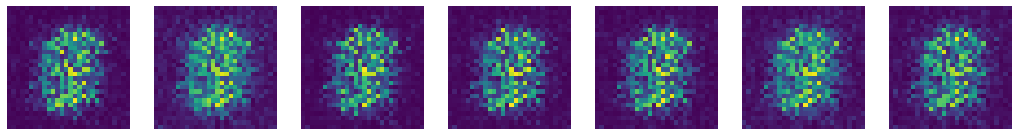

Epoch 5: dloss 0.7629954814910889     gloss 0.8203691244125366


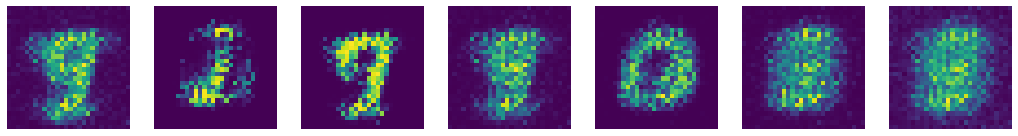

Epoch 10: dloss 0.7168397903442383     gloss 0.90338134765625


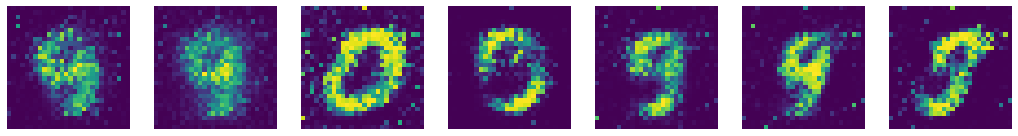

Epoch 15: dloss 0.7283837199211121     gloss 1.176879644393921


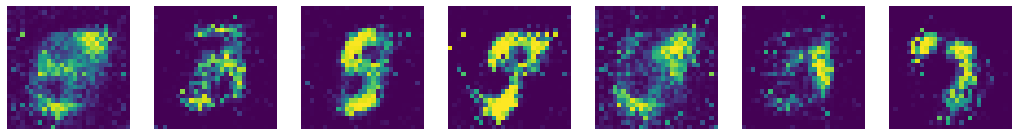

Epoch 20: dloss 0.7025654911994934     gloss 1.3192071914672852


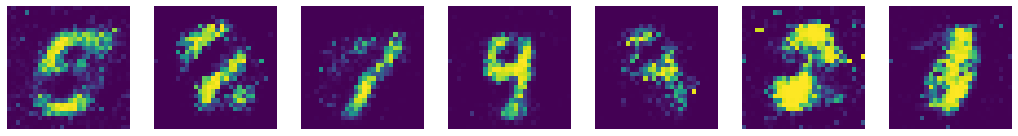

Epoch 25: dloss 0.7517445683479309     gloss 0.9039032459259033


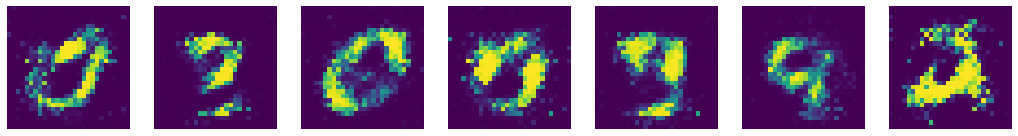

Epoch 30: dloss 0.6458794474601746     gloss 1.0158792734146118


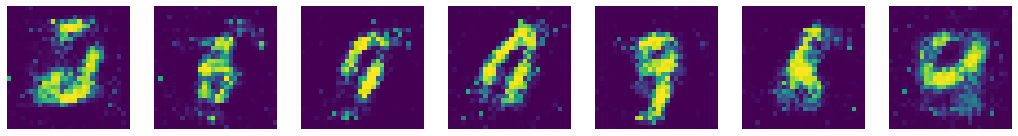

Epoch 35: dloss 0.5876580476760864     gloss 1.0735769271850586


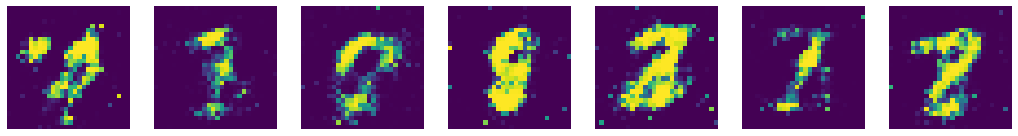

Epoch 40: dloss 0.7722750306129456     gloss 0.8643790483474731


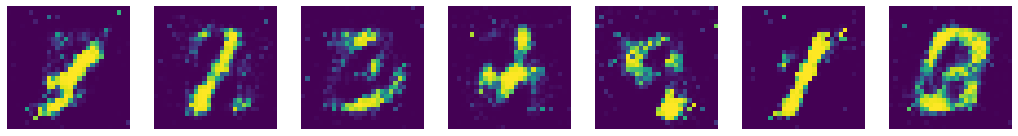

Epoch 45: dloss 0.6944535970687866     gloss 0.8314312696456909


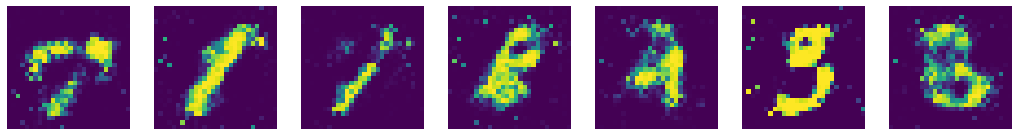

Epoch 50: dloss 0.6594996452331543     gloss 1.1339988708496094


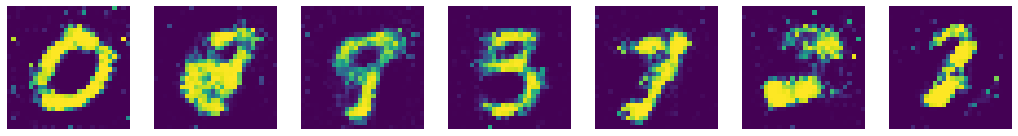

Epoch 55: dloss 0.606029212474823     gloss 0.9102145433425903


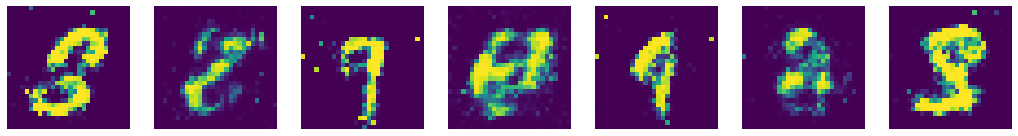

Epoch 60: dloss 0.5980324745178223     gloss 0.8565263748168945


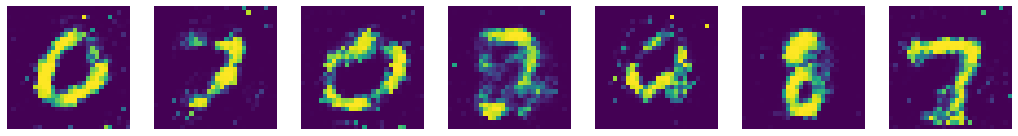

Epoch 65: dloss 0.617893636226654     gloss 0.8523918390274048


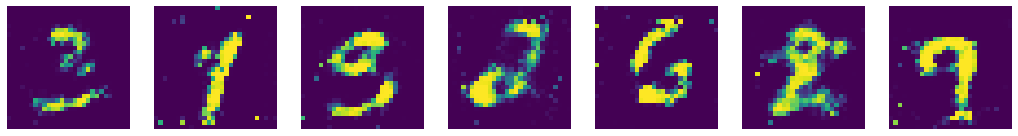

Epoch 70: dloss 0.6013215780258179     gloss 1.0875990390777588


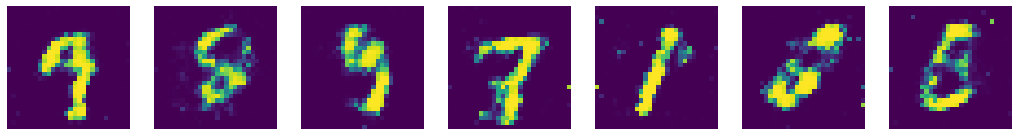

Epoch 75: dloss 0.5226178169250488     gloss 0.913964033126831


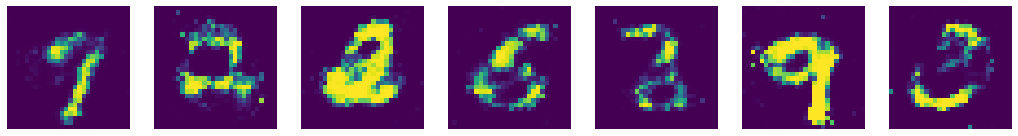

Epoch 80: dloss 0.5344909429550171     gloss 0.9958906769752502


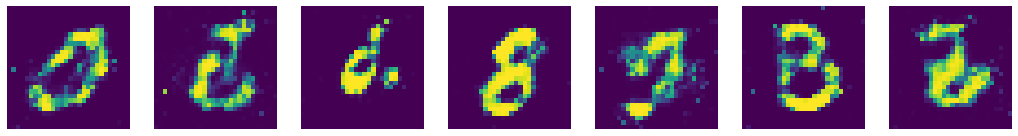

Epoch 85: dloss 0.5330058932304382     gloss 0.9791241884231567


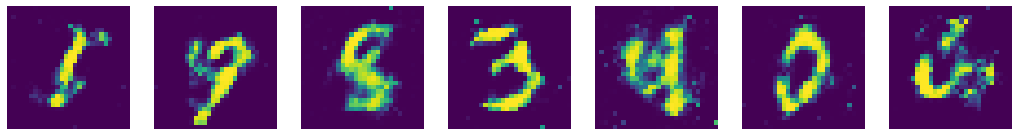

Epoch 90: dloss 0.44789689779281616     gloss 1.272139549255371


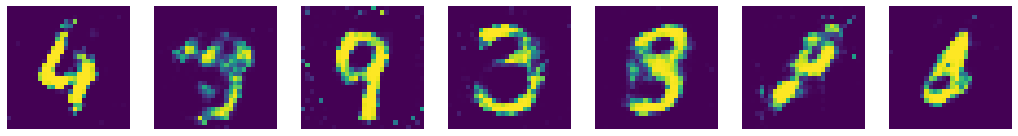

Epoch 95: dloss 0.6242159008979797     gloss 0.7654480934143066


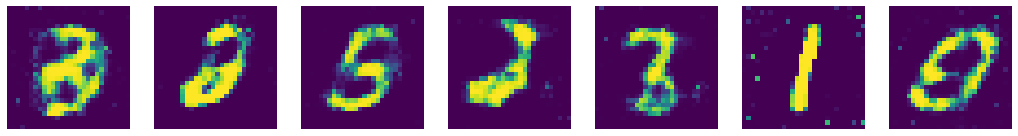

Epoch 100: dloss 0.5449418425559998     gloss 1.0448795557022095


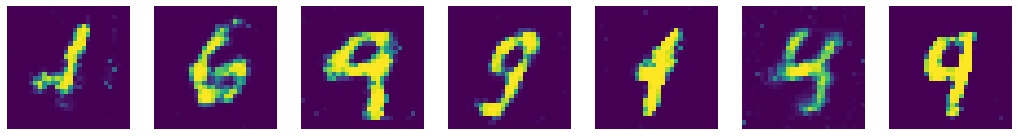

Epoch 105: dloss 0.5362544655799866     gloss 1.0476322174072266


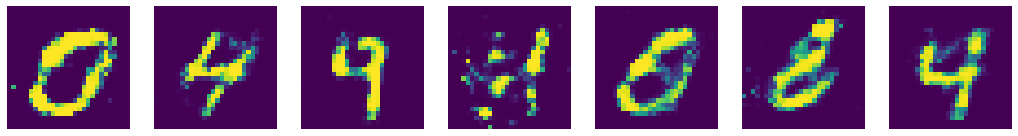

Epoch 110: dloss 0.5692617297172546     gloss 1.2287203073501587


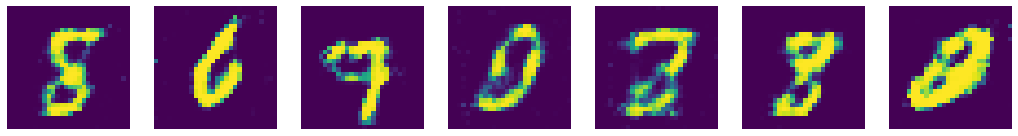

Epoch 115: dloss 0.6574455499649048     gloss 1.0367944240570068


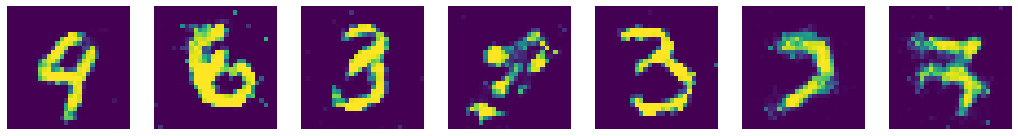

Epoch 120: dloss 0.612603485584259     gloss 1.1021583080291748


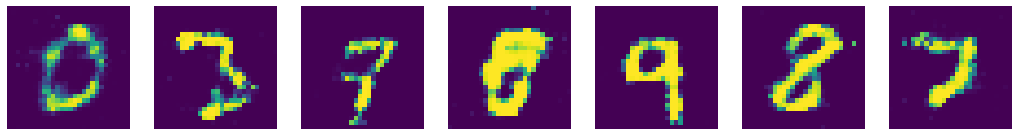

Epoch 125: dloss 0.5732893943786621     gloss 0.9611930251121521


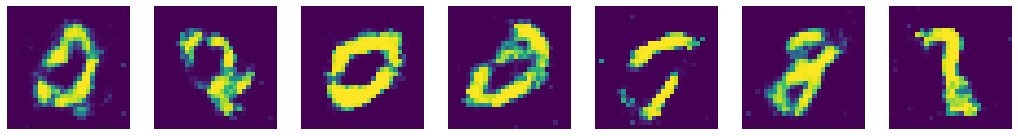

Epoch 130: dloss 0.5957831144332886     gloss 1.0870680809020996


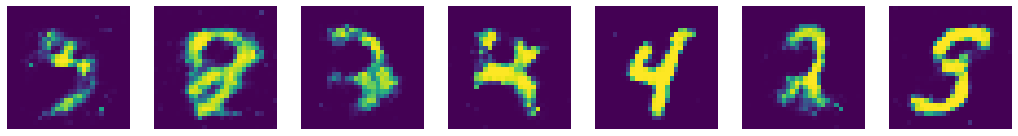

Epoch 135: dloss 0.5661388039588928     gloss 0.9797914624214172


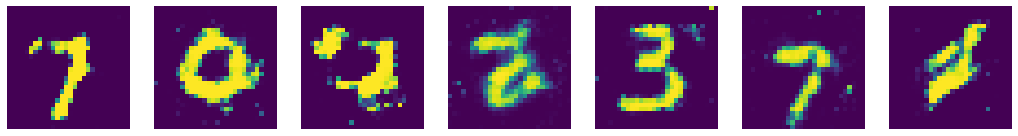

Epoch 140: dloss 0.5578914284706116     gloss 1.264491081237793


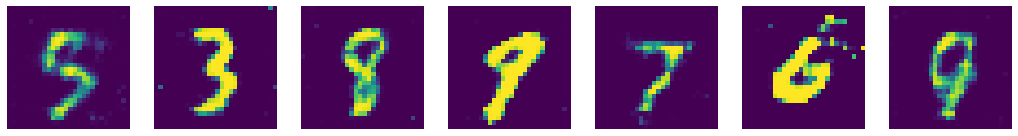

Epoch 145: dloss 0.6409033536911011     gloss 0.8866556882858276


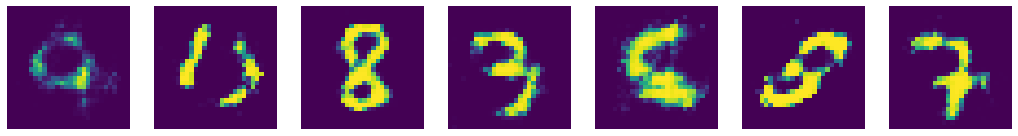

Epoch 150: dloss 0.5531330704689026     gloss 1.0414516925811768


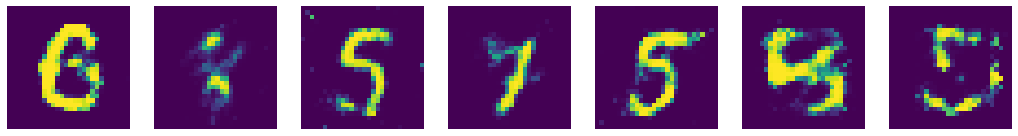

Epoch 155: dloss 0.47105711698532104     gloss 1.0963842868804932


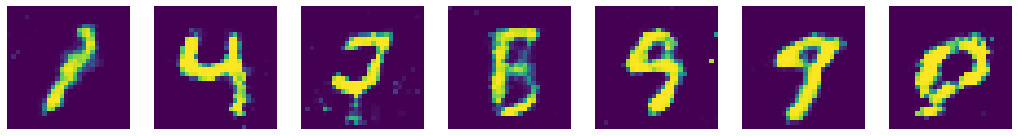

Epoch 160: dloss 0.5355952978134155     gloss 1.40745210647583


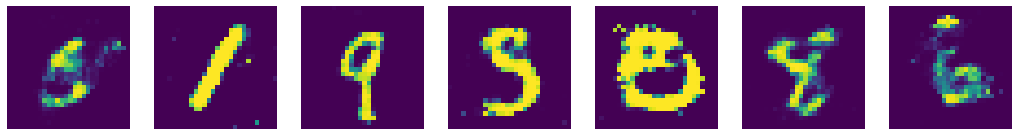

Epoch 165: dloss 0.5367348790168762     gloss 1.1232430934906006


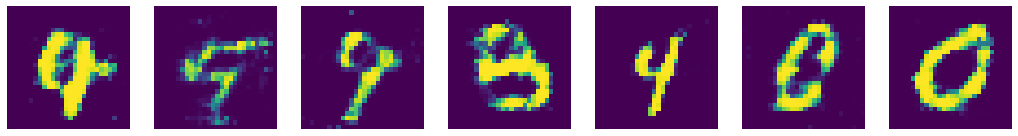

Epoch 170: dloss 0.5743275880813599     gloss 1.0922143459320068


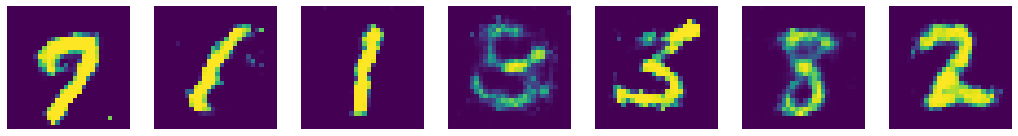

Epoch 175: dloss 0.5385532379150391     gloss 1.002015471458435


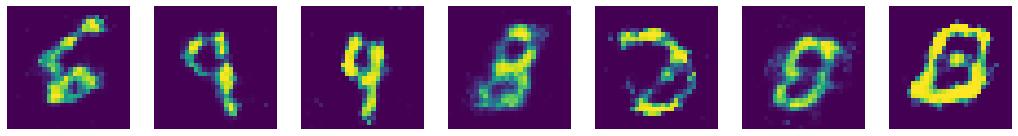

Epoch 180: dloss 0.6166565418243408     gloss 1.05759859085083


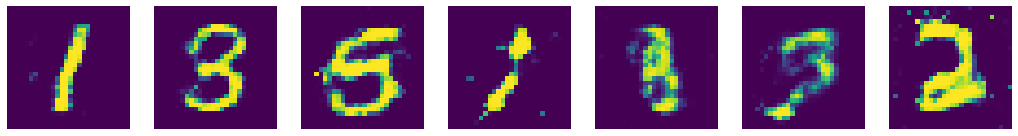

Epoch 185: dloss 0.4905123710632324     gloss 1.2851316928863525


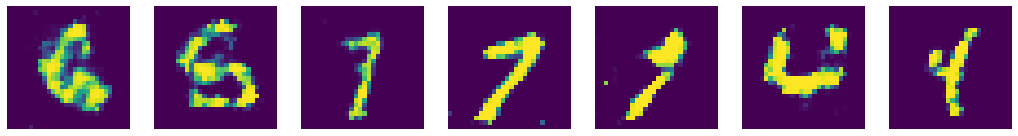

Epoch 190: dloss 0.5241207480430603     gloss 1.3794293403625488


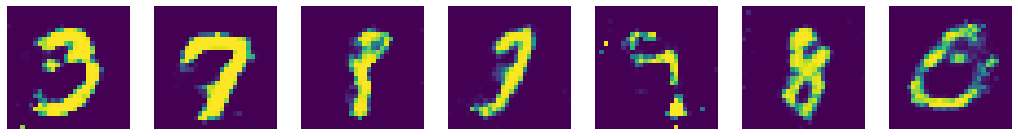

Epoch 195: dloss 0.5105255246162415     gloss 1.243360996246338


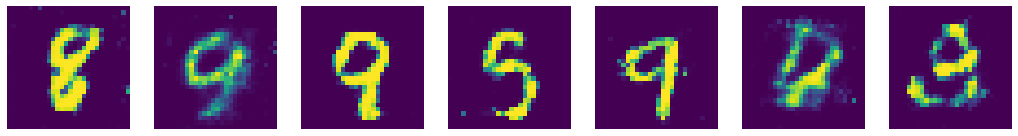

In [43]:
import matplotlib.pyplot as plt
import numpy

dlosses, glosses = [], []
fixed_noise = torch.randn(7, z_dim).to(device)

for epoch in range(epochs):
    for idx, (real, _) in enumerate(dataloader):
        real = real.view(-1, 784).to(device)
        noise = torch.randn(batch_size, z_dim).to(device)
        
        # discriminator
        fake = gen(noise)
        dis_real = dis(real).view(-1)
        loss_dis_real = criterion(dis_real, torch.ones_like(dis_real))
        dis_fake = dis(fake).view(-1)
        loss_dis_fake = criterion(dis_fake, torch.zeros_like(dis_fake))
        loss_dis = (loss_dis_real + loss_dis_fake)/2
        dis.zero_grad()
        loss_dis.backward(retain_graph=True)
        optim_dis.step()

        # generator
        output = dis(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optim_gen.step()

        if idx%100 == 0:
            dlosses.append(loss_dis.detach().item())
            glosses.append(loss_gen.detach().item())
    
    
    if epoch%5 == 0:
        print(f'Epoch {epoch}: dloss {loss_dis}     gloss {loss_gen}')

        # visualize
        noise = torch.randn(7, z_dim).to(device)
        fake = gen(noise)
        fake = fake.reshape([7,28,28])
        fig, axs = plt.subplots(1, 7, figsize=(18,5))

        for i in range(7):
            data = fake[i].cpu().detach().numpy()
            axs[i].imshow(data)
        for ax in axs:
            ax.axis('off')

        plt.show()
    

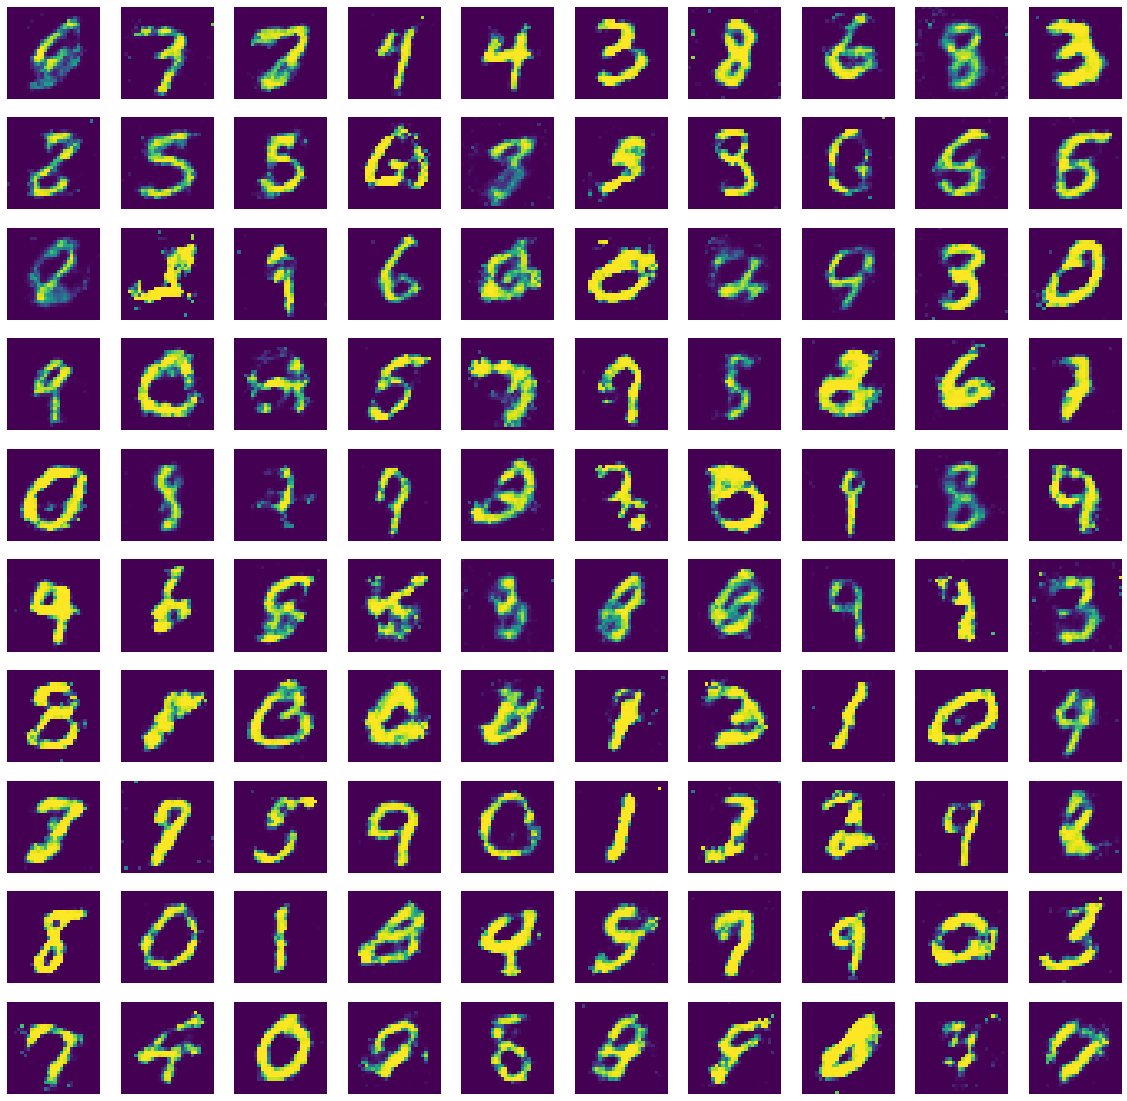

In [47]:
noise = torch.randn(100, z_dim).to(device)
fake = gen(noise)
fake = fake.reshape([100,28,28])
fig, axs = plt.subplots(10, 10, figsize=(20,20))
for i, ax in enumerate(axs.flat):
    data = fake[i].cpu().detach().numpy()
    ax.imshow(data)
    ax.axis('off')

plt.show()

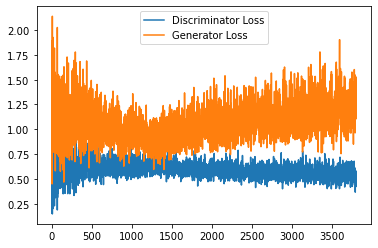

In [45]:
plt.figure()
plt.plot(dlosses[:], label="Discriminator Loss")
plt.plot(glosses[:], label="Generator Loss")
plt.legend()
